In [1]:
import sys
import os
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import regionmask
import rioxarray
from shapely.geometry import mapping, Point, Polygon

In [2]:
# Define project repo path
inDirName = '/Users/smurugan9/research/aislens/aislens_emulation/'
# Data file paths
regriddedFluxSSH_filepath = 'data/interim/RegriddedFluxSSH.nc' # Data containing regridded flux and SSH for 150 years
iceShelvesShape_filepath = 'data/interim/iceShelves.geojson' # File contains all defined ice shelves

In [11]:
icems.name.values[72]

'Larsen_B'

In [6]:
icems.name.values

array(['Filchner-Ronne', 'Ross', 'Antarctica', 'Peninsula',
       'West Antarctica', 'East Antarctica', 'IMBIE1', 'IMBIE2', 'IMBIE3',
       'IMBIE4', 'IMBIE5', 'IMBIE6', 'IMBIE7', 'IMBIE8', 'IMBIE9',
       'IMBIE10', 'IMBIE11', 'IMBIE12', 'IMBIE13', 'IMBIE14', 'IMBIE15',
       'IMBIE16', 'IMBIE17', 'IMBIE18', 'IMBIE19', 'IMBIE20', 'IMBIE21',
       'IMBIE22', 'IMBIE23', 'IMBIE24', 'IMBIE25', 'IMBIE26', 'IMBIE27',
       'Abbot', 'Amery', 'Atka', 'Aviator', 'Bach', 'Baudouin',
       'Borchgrevink', 'Brahms', 'Brunt_Stancomb', 'Campbell', 'Cheetham',
       'Conger_Glenzer', 'Cook', 'Cosgrove', 'Crosson', 'Dennistoun',
       'Dibble', 'Dotson', 'Drygalski', 'Edward_VIII', 'Ekstrom',
       'Ferrigno', 'Filchner', 'Fimbul', 'Fitzgerald', 'Frost',
       'GeikieInlet', 'George_VI', 'Getz', 'Gillet', 'Hamilton', 'Hannan',
       'HarbordGlacier', 'Helen', 'Holmes', 'HolmesWest', 'Hull',
       'Jelbart', 'Land', 'Larsen_B', 'Larsen_C', 'Larsen_D', 'Larsen_E',
       'Larsen_F', 'Larse

/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


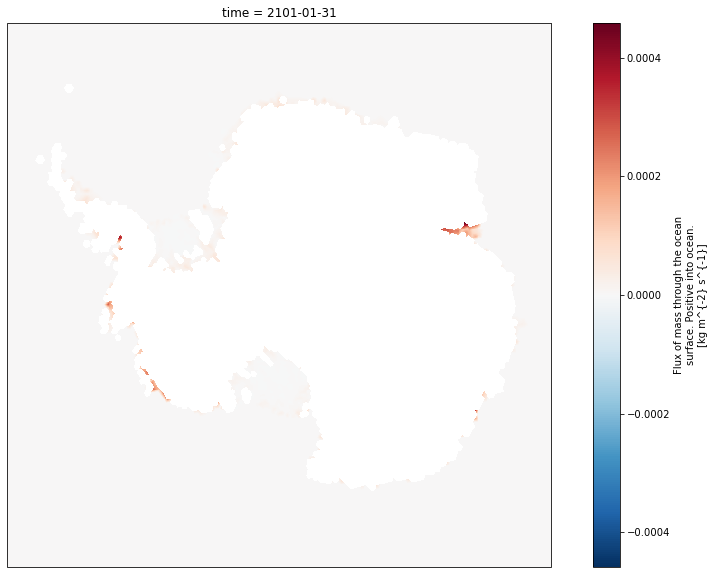

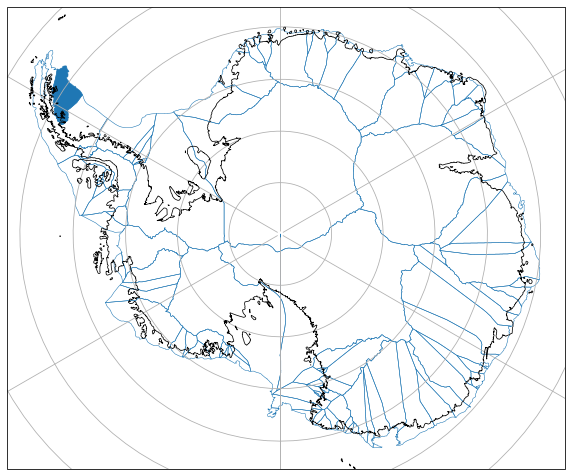

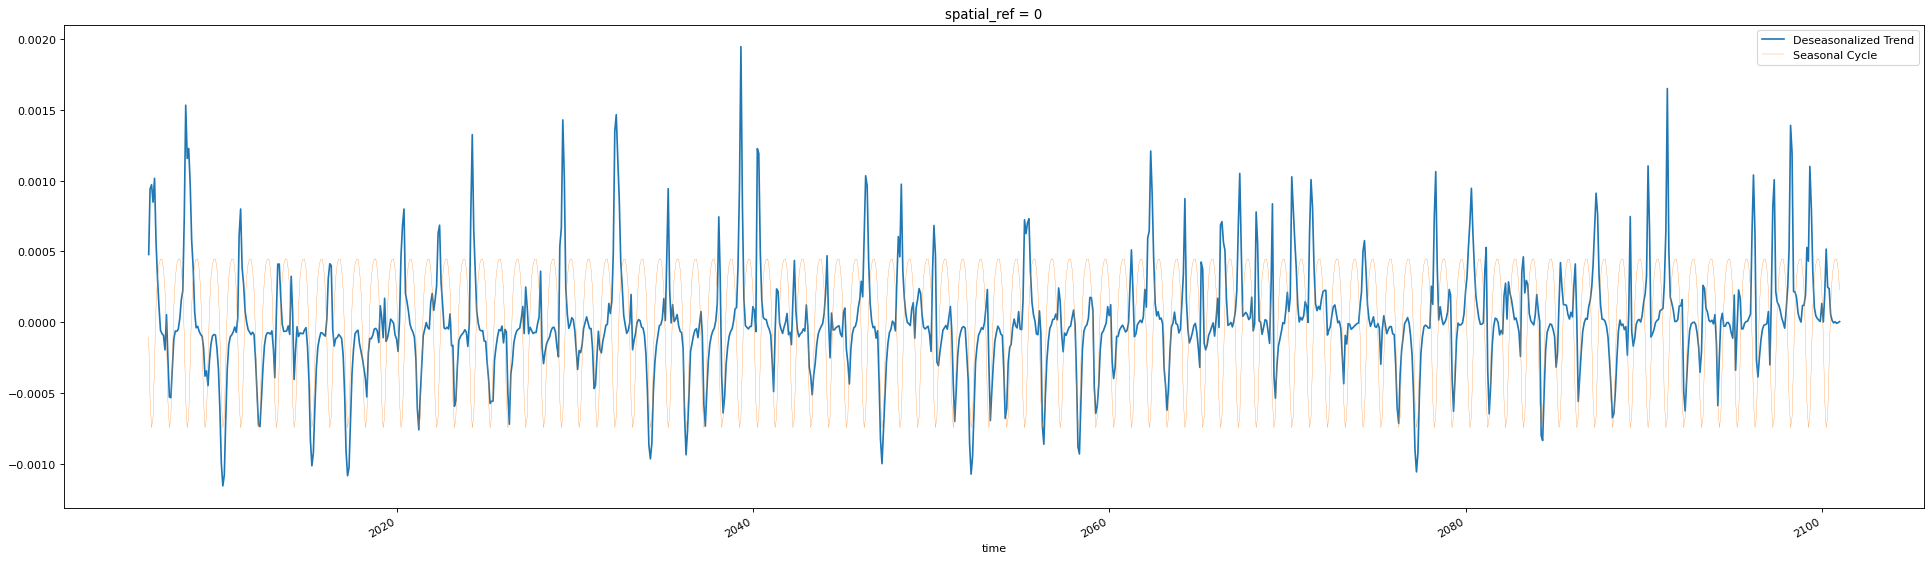

In [12]:
data = xr.open_dataset(inDirName + regriddedFluxSSH_filepath)
flux = data.timeMonthly_avg_landIceFreshwaterFlux
ssh = data.timeMonthly_avg_ssh
lat = data.lat
lon = data.lon

# Presents a sample plot of the entire ice sheet with the flux data at any time stamp

# Time stamp
ts = 1200

plt.figure(figsize=(15,10))
ax = plt.subplot(111,projection=ccrs.SouthPolarStereo())
#ax.gridlines()
# ax.coastlines(resolution='10m',linewidth=0.75)
# flux[ts].plot.contourf(ax=ax,levels=30)
flux[ts].plot()
# flux.mean('time').plot()
# icems.boundary.loc[[basin]].plot(ax=ax,color='blue',linewidth=0.25)


# Read geoJSON region feature file as POLYGON (GeoDataFrame)
iceshelvesmask = gpd.read_file(inDirName + iceShelvesShape_filepath)

# convert to south polar stereographic projection
icems = iceshelvesmask.to_crs({'init': 'epsg:3031'})
crs = ccrs.SouthPolarStereo()

#Masked data
data.rio.write_crs("epsg:3031",inplace=True)

## Following section tests the code for 1 ice shelf / catchment:
# Iceshelf chosen: 
#  34 : Amery
# 103 : Ronne
# 104 : Western Ross
# 105 : Eastern Ross
# 114 : Thwaites

basin = 72
basinName = icems.name.values[basin]

plt.figure(figsize=(10,10))
ax = plt.subplot(111,projection=ccrs.SouthPolarStereo())
ax.gridlines()
icems[34:133].boundary.plot(ax=ax,linewidth=0.5)
ax.coastlines(resolution='10m', zorder=6,linewidth=0.75)
icems.loc[[basin]].plot(ax=ax)

# Mask data to chosen basin
#  34 : Amery
# 104 : Western Ross
# 105 : Eastern Ross
# 114 : Thwaites
ds = data.rio.clip(icems.loc[[basin],'geometry'].apply(mapping),icems.crs,drop=False)

flx = ds.timeMonthly_avg_landIceFreshwaterFlux
h = ds.timeMonthly_avg_ssh

# lmax = np.max(flx)
# lmin = np.min(flx)

flx_series = flx.sum(['y','x'])

def detrend_dim(data, dim, deg):
    # detrend along a single dimension
    p = data.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(data[dim], p.polyfit_coefficients)
    return data - fit

flx_detrended = detrend_dim(flx, 'time', 1)

# Integrate flux across basin for time series
flx_detrended_series = flx_detrended.sum(['y','x'], skipna=True)

# Deseasonalize with monthly means
flx_monthly = flx_detrended.groupby("time.month")
flx_deseasonalized = flx_monthly - flx_monthly.mean("time")
flx_deseasonalized_series = flx_deseasonalized.sum(['y','x'], skipna=True)

plt.figure(figsize=(30, 8), dpi=80)
seasonal_diff = flx_deseasonalized_series - flx_detrended_series
flx_deseasonalized_series[60:1200].plot(label = 'Deseasonalized Trend')
# fl_sum.plot()
seasonal_diff[60:1200].plot(label = 'Seasonal Cycle', linewidth=0.25)
plt.legend()

Text(0.5, 1.0, 'ACF: Larsen_B, Monthly Means')

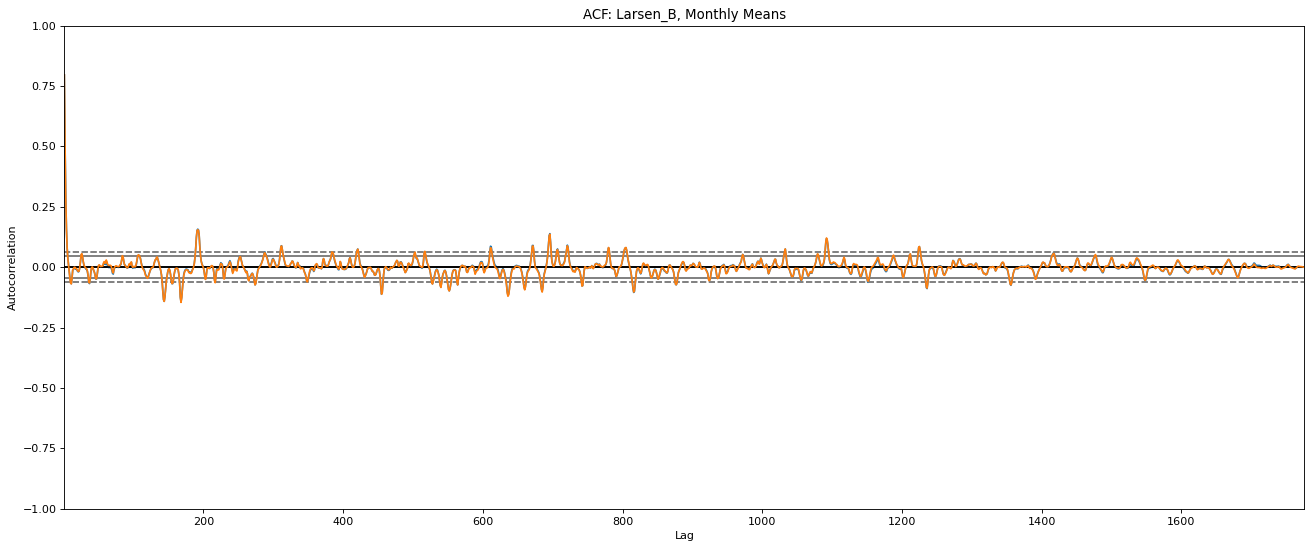

In [13]:
# plot autocorrelation
plt.figure(figsize=(20, 8), dpi=80)

fl = flx_deseasonalized_series[24:]
plt.clf()
fl_fourier = np.fft.rfft(fl)

# random_phases = np.exp(np.random.uniform(0,np.pi,int(len(fl)/2+1))*1.0j)
random_phases = np.exp(np.random.uniform(0,np.pi)*1.0j)

fl_fourier_new = fl_fourier*random_phases

new_fl = np.fft.irfft(fl_fourier_new)

pd.plotting.autocorrelation_plot(fl)
pd.plotting.autocorrelation_plot(new_fl)
plt.ylabel('Autocorrelation')
plt.title('ACF: {}, Monthly Means'.format(basinName))
#plt.savefig('{}_flux_ACF_dedrafted.png'.format(basinName))

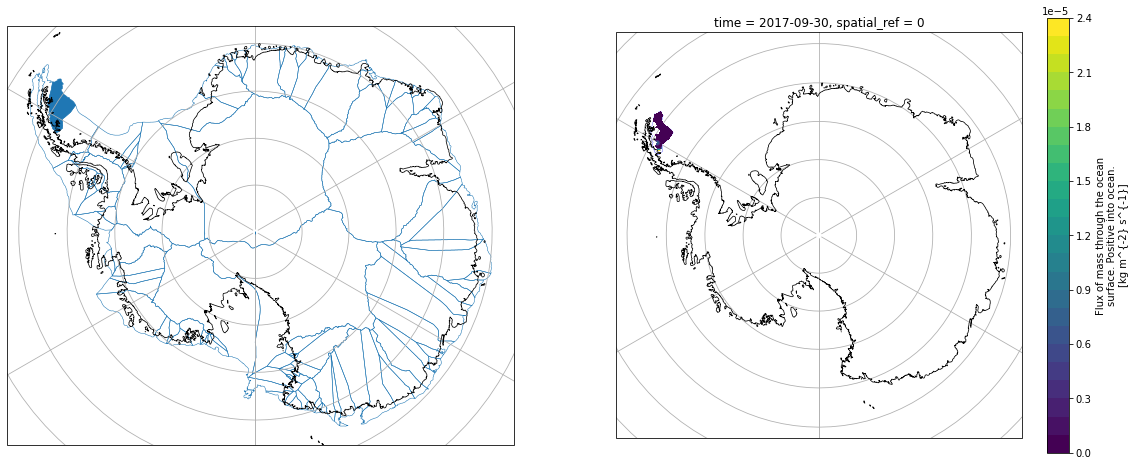

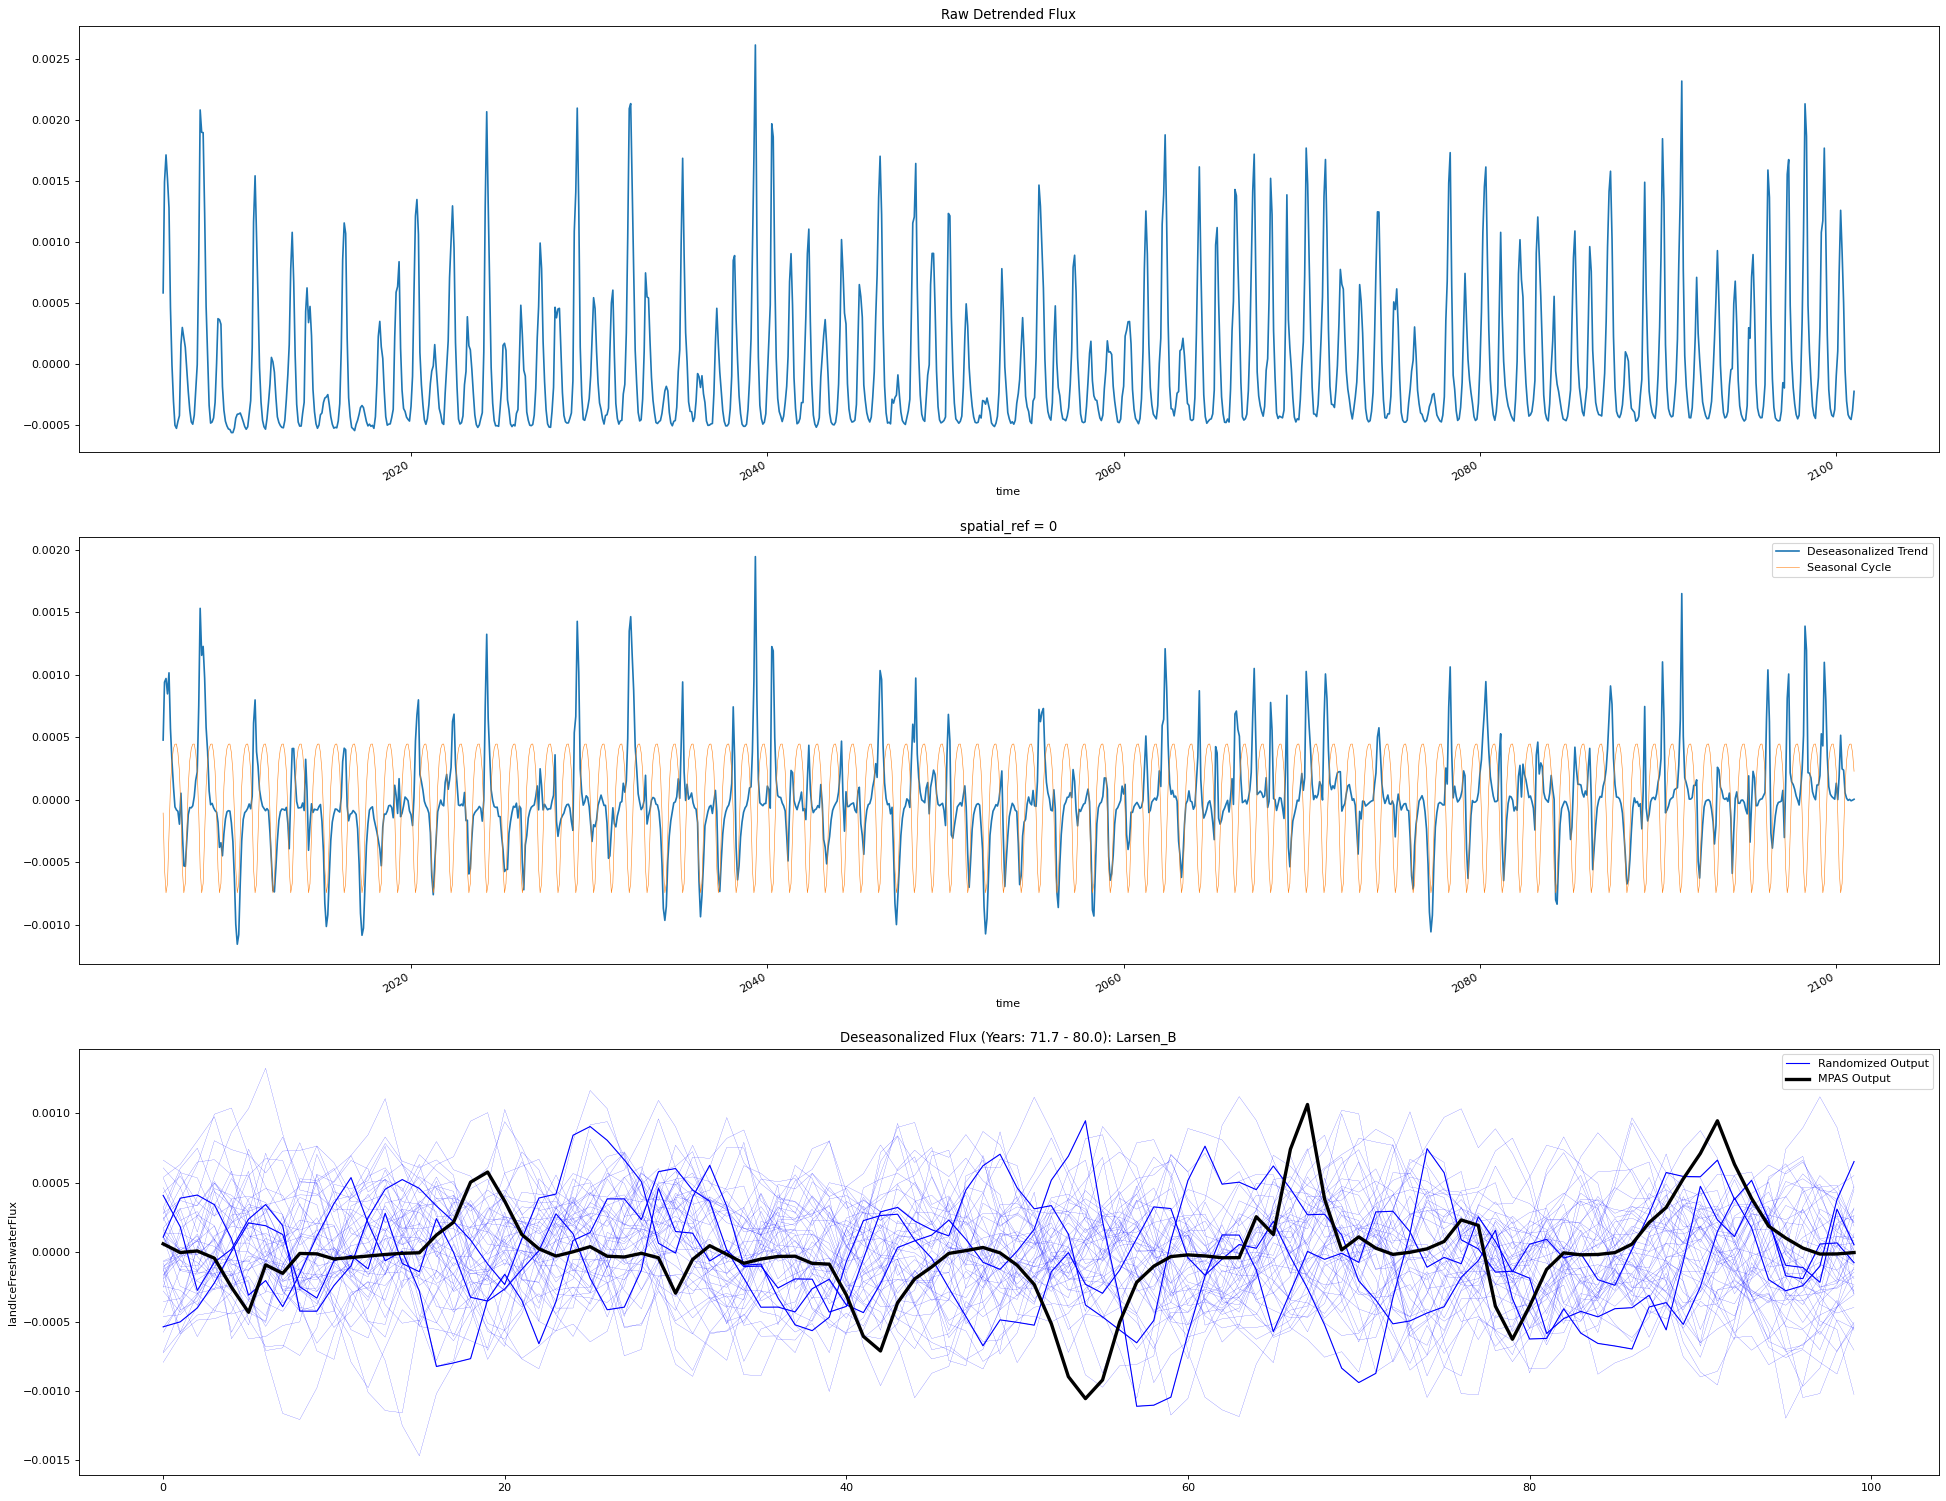

In [22]:
plt.figure(figsize=(20,8))
ax1 = plt.subplot(121,projection=ccrs.SouthPolarStereo())
ax1.gridlines()
icems[34:133].boundary.plot(ax=ax1,linewidth=0.5)
ax1.coastlines(resolution='10m', zorder=6,linewidth=0.75)
icems.loc[[basin]].plot(ax=ax1)

# Presents a sample plot of the ice shelf under question with the flux data at any time stamp

# Time stamp
ts = 200

# plt.figure(figsize=(10,8))
ax2 = plt.subplot(122,projection=ccrs.SouthPolarStereo())
ax2.gridlines()
ax2.coastlines(resolution='10m', zorder=3,linewidth=0.75)
# flx[10].plot.contourf(ax=ax,levels=np.linspace(lmin,lmax,30))
flx[ts].plot.contourf(ax=ax2,levels=30,zorder=6)
# flx[ts].plot()
icems.boundary.loc[[basin]].plot(ax=ax2,color='blue',linewidth=0.25)



# change this to remove first few datapoints
tstart = 24
plt.figure(figsize=(30, 24), dpi=80)
plt.subplot(311)
flx_detrended_series[60:1200].plot()
plt.title('Raw Detrended Flux')


plt.subplot(312)
seasonal_diff = flx_deseasonalized_series - flx_detrended_series
flx_deseasonalized_series[60:1200].plot(label = 'Deseasonalized Trend')
# fl_sum.plot()
seasonal_diff[60:1200].plot(label = 'Seasonal Cycle', linewidth=0.5)
plt.legend()



# plot autocorrelation
# plt.figure(figsize=(20, 10), dpi=80)

plt.subplot(313)
spinuptime = 60 # Ignore first few years of data in the phase randomization
n_realizations = 50 # Number of random Fourier realizations

new_fl = np.empty((n_realizations,flx_deseasonalized_series[spinuptime:].size))

# Time limits for plotting
t1 = 800
tf = 900

for i in range(n_realizations):    
    fl = flx_deseasonalized_series[spinuptime:]
    fl_fourier = np.fft.rfft(fl)
    # random_phases = np.exp(np.random.uniform(0,np.pi)*1.0j)
    random_phases = np.exp(np.random.uniform(0,2*np.pi,int(len(fl)/2+1))*1.0j)
    fl_fourier_new = fl_fourier*random_phases
    new_fl[i,:] = np.fft.irfft(fl_fourier_new)
    plt.plot(new_fl[i,t1:tf],'b', linewidth=0.15)

plt.plot(new_fl[45,t1:tf],'b', linewidth=1, label='Randomized Output')
plt.plot(new_fl[10,t1:tf],'b', linewidth=1)
plt.plot(new_fl[40,t1:tf],'b', linewidth=1)
plt.plot(fl[t1:tf],'k', linewidth=3, label='MPAS Output')
plt.title('Deseasonalized Flux (Years: {:.1f} - {:.1f}): {}'.format((spinuptime+t1)/12,(spinuptime+tf)/12,basinName))
plt.ylabel('landIceFreshwaterFlux')
plt.legend()